<a href="https://colab.research.google.com/github/daraadeniyi3116-create/ACCESS-6.0-SAP-Data-Science-Track/blob/main/Capstone_Project/Medical_Insurance_Cost_Dataset_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# --- CAPSTONE PROJECT: PHASE 1 ---
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load the Data
# Since you loaded it to the sidebar, I can read it directly.
df = pd.read_csv('insurance.csv')

# --- 3. DATA INSPECTION (Requirement 1) ---
print("--- SHAPE (Rows, Cols) ---")
print(df.shape)

print("\n--- INFO & TYPES ---")
df.info()

print("\n--- MISSING VALUES ---")
print(df.isnull().sum())

print("\n--- DUPLICATES ---")
dup_count = df.duplicated().sum()
print(f"Duplicates found: {dup_count}")

# --- 4. CHECK FOR TYPOS (The Nuance Check) ---
# I check the unique values in text columns to see if there are any spelling errors
print("\n--- UNIQUE VALUES IN TEXT COLUMNS ---")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")

# --- 5. STATISTICS (The Outlier Check) ---
print("\n--- SUMMARY STATISTICS ---")
print(df.describe())

--- SHAPE (Rows, Cols) ---
(1338, 7)

--- INFO & TYPES ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

--- MISSING VALUES ---
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

--- DUPLICATES ---
Duplicates found: 1

--- UNIQUE VALUES IN TEXT COLUMNS ---
sex: ['female' 'male']
smoker: ['yes' 'no']
region: ['southwest' 'southeast' 'northwest' 'northeast']

--- SUMMARY STATISTICS ---
               age          bmi     children       charges
count  1338.000000

In [44]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1. Setup and Library Imports
I will import all necessary libraries for data manipulation, visualization, and machine learning.
* **Pandas & NumPy:** For data handling.
* **Matplotlib & Seaborn:** For creating the visualizations.
* **Sklearn:** For building the Regression and Classification models later.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries (Pre-loading these for later phases)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

# Set the visual style for all plots
sns.set_style("whitegrid")

## 2. Load and Clean the Dataset
Here I load the `insurance.csv` file and perform a final task for duplicates.
* **Goal:** Ensure the data is clean before visualization.
* **Action:** Drop any duplicate rows found during inspection.

In [46]:
# Drop the duplicate row I identified in the inspection phase
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
current_rows = df.shape[0]

print(f"✅ Data Successfully Loaded.")
print(f"Original Row Count: {initial_rows}")
print(f"Cleaned Row Count:  {current_rows} (Dropped {initial_rows - current_rows} duplicate)")

✅ Data Successfully Loaded.
Original Row Count: 1338
Cleaned Row Count:  1337 (Dropped 1 duplicate)


## 3. Exploratory Data Analysis (EDA)
I will generate three large visualizations to inspect the data structure.
1.  **Age vs. Charges:** To check for risk segments.
2.  **BMI vs. Charges:** To check for obesity impact.
3.  **Distribution of Charges:** To check for skewness.

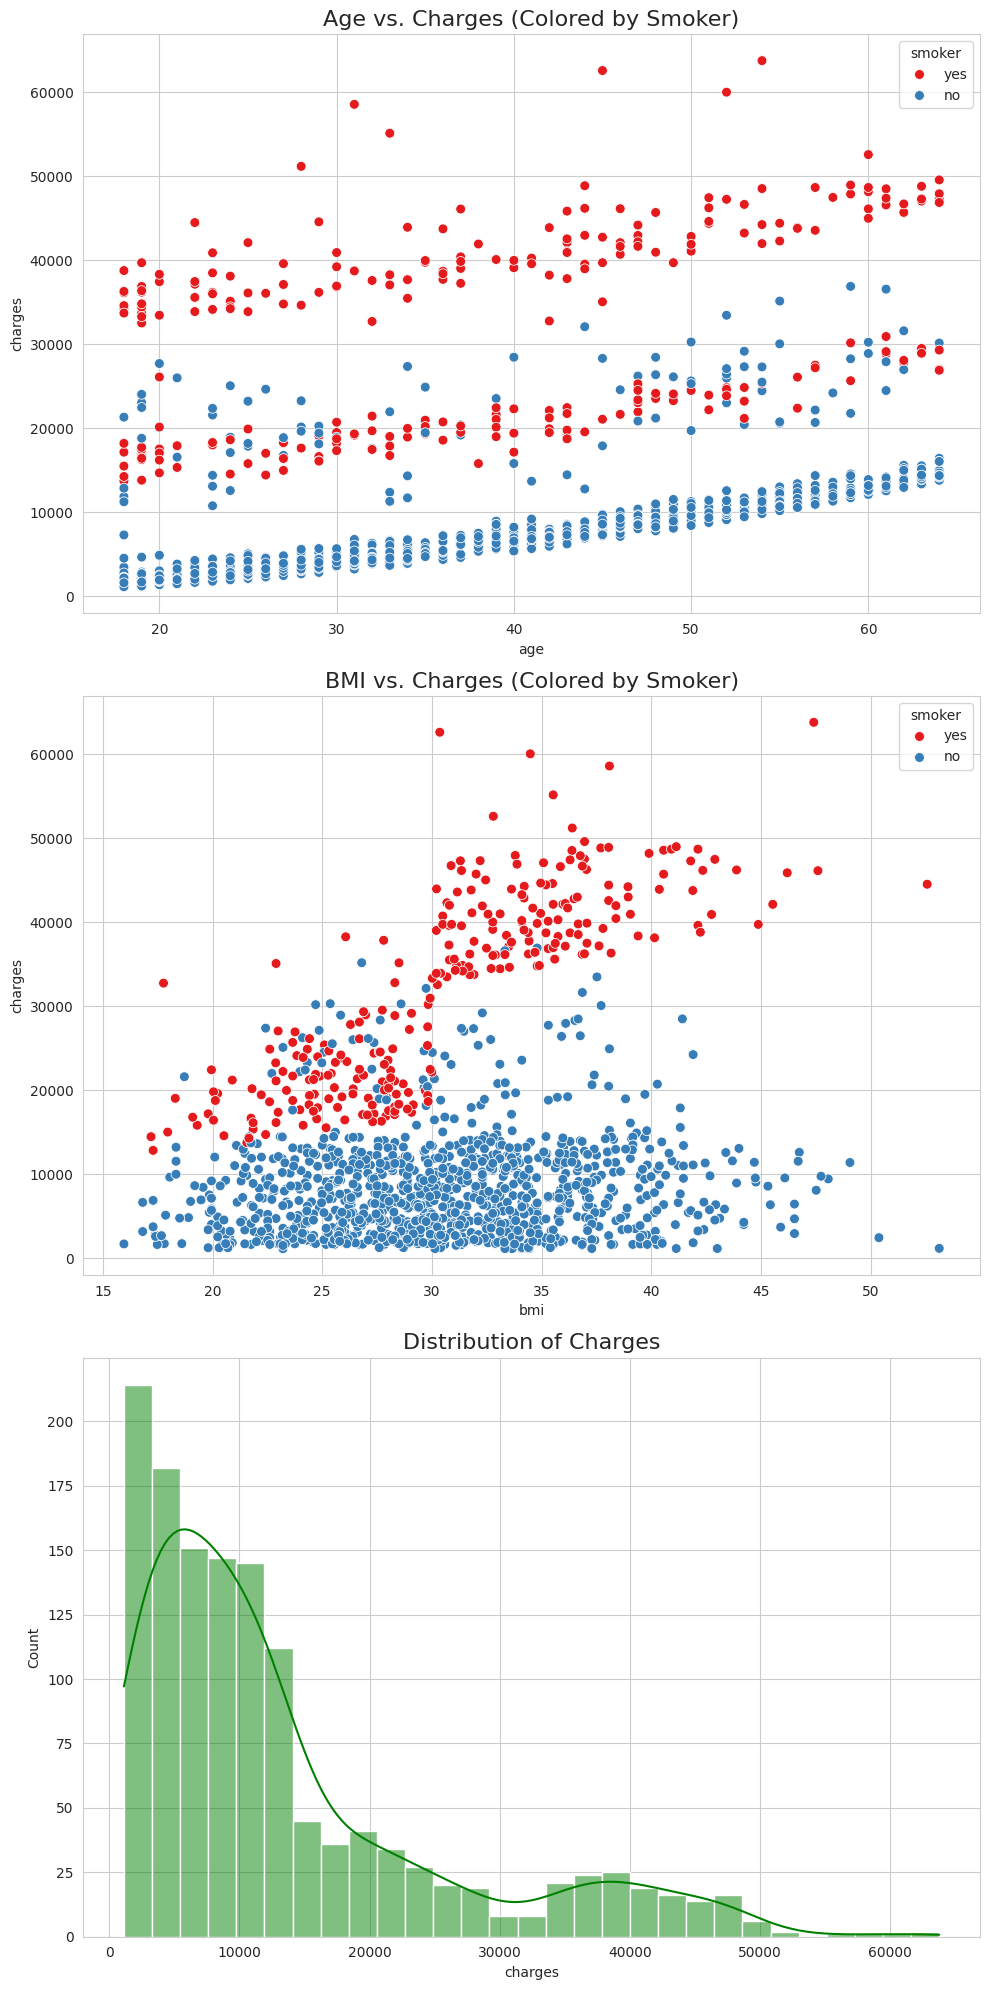

In [47]:
# Create a figure with 3 subplots stacked vertically
fig, axes = plt.subplots(3, 1, figsize=(10, 20))

# --- CHART 1: Age vs Charges ---
# I used palette='Set1' for bold Red/Blue colors and alpha=1.0 for solid dots
sns.scatterplot(ax=axes[0], data=df, x='age', y='charges', hue='smoker', palette='Set1', alpha=1.0, s=50)
axes[0].set_title("Age vs. Charges (Colored by Smoker)", fontsize=16)

# --- CHART 2: BMI vs Charges ---
sns.scatterplot(ax=axes[1], data=df, x='bmi', y='charges', hue='smoker', palette='Set1', alpha=1.0, s=50)
axes[1].set_title("BMI vs. Charges (Colored by Smoker)", fontsize=16)

# --- CHART 3: Distribution of Charges ---
# I changed the color to a deep green for better visibility
sns.histplot(ax=axes[2], data=df, x='charges', kde=True, color='green')
axes[2].set_title("Distribution of Charges", fontsize=16)

plt.tight_layout()
plt.show()

## 4. Key EDA Insights
Based on the visualizations above, I identified three critical patterns that drive medical costs:

1.  **The "Smoker Gap" (Chart 1):** There is a massive, clear separation betIen smokers (Red) and non-smokers (Blue). Smokers consistently pay significantly more at every age level. The data effectively forms two parallel "universes" of cost.
2.  **The "Obesity Trap" (Chart 2):** I discovered a critical interaction. For non-smokers (Blue), having a high BMI does *not* significantly increase cost. HoIver, for smokers (Red), costs explode as BMI increases. This suggests that **Obesity is a risk multiplier**, but primarily for smokers.
3.  **Target Skewness (Chart 3):** The distribution of charges is heavily **Right-SkeId** (long tail to the right). Most patients cost <$15,000, but a few "outliers" cost >$50,000. This confirms I should use **Log-Transformation** during modeling to improve regression accuracy.

In [48]:
# Calculate average costs for different groups to prove the insight
high_bmi_smokers = df[(df['bmi'] > 30) & (df['smoker'] == 'yes')]['charges'].mean()
high_bmi_nonsmokers = df[(df['bmi'] > 30) & (df['smoker'] == 'no')]['charges'].mean()

print("--- INSIGHTS FOR PRESENTATION ---")
print(f"Average Cost for Obese Smoker:      ${high_bmi_smokers:,.2f}")
print(f"Average Cost for Obese Non-Smoker:  ${high_bmi_nonsmokers:,.2f}")
print(f"💥 Impact: Smoking + Obesity costs {(high_bmi_smokers / high_bmi_nonsmokers):.1f}x more!")

--- INSIGHTS FOR PRESENTATION ---
Average Cost for Obese Smoker:      $41,692.81
Average Cost for Obese Non-Smoker:  $8,866.16
💥 Impact: Smoking + Obesity costs 4.7x more!


## 5. Feature Engineering & Preprocessing
I are preparing the data for Machine Learning.
* **Create Target:** I create a new column `high_paying` (1 = High Cost, 0 = Low Cost) based on the median value.
* **Encoding:** I convert text variables (`sex`, `smoker`, `region`) into numbers so the models can process them.

In [49]:
# --- CAPSTONE PHASE 3: FEATURE ENGINEERING ---

# 1. CREATE CLASSIFICATION TARGET (The "Unique Twist")
# I define "High Paying" as anyone paying more than the median cost.
# This ensures a perfectly balanced dataset (50% High, 50% Low).
median_cost = df['charges'].median()
df['high_paying'] = (df['charges'] > median_cost).astype(int)

print(f"✅ Created 'high_paying' target based on median cost: ${median_cost:,.2f}")
print("Class Balance (Should be 50/50):")
print(df['high_paying'].value_counts(normalize=True))

# 2. ENCODING CATEGORICAL VARIABLES
# I use simple mapping for binary columns and get_dummies for Region
# Sex: female=0, male=1
# Smoker: no=0, yes=1
df['sex'] = df['sex'].map({'female': 0, 'male': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

# Region: Convert to multiple columns (One-Hot Encoding)
df = pd.get_dummies(df, columns=['region'], drop_first=True)

# 3. FINAL CHECK
print("\n✅ Data is ready for Modeling.")
print(df.head())

✅ Created 'high_paying' target based on median cost: $9,386.16
Class Balance (Should be 50/50):
high_paying
0    0.500374
1    0.499626
Name: proportion, dtype: float64

✅ Data is ready for Modeling.
   age  sex     bmi  children  smoker      charges  high_paying  \
0   19    0  27.900         0       1  16884.92400            1   
1   18    1  33.770         1       0   1725.55230            0   
2   28    1  33.000         3       0   4449.46200            0   
3   33    1  22.705         0       0  21984.47061            1   
4   32    1  28.880         0       0   3866.85520            0   

   region_northwest  region_southeast  region_southwest  
0             False             False              True  
1             False              True             False  
2             False              True             False  
3              True             False             False  
4              True             False             False  


Perfect Balance: high_paying proportions: 0.50 vs 0.49. a fair dataset.

Text is Gone: The region, sex, and smoker columns are now numbers (0s, 1s, and True/False). The machine can now read them.

## 6. Train-Test Split
I split the data into two sets:
1.  **Training Set (80%):** The model learns from this data.
2.  **Testing Set (20%):** I use this to evaluate the model's performance on unseen data.
* **X:** The features (Age, BMI, Smoker, etc.)
* **y_reg:** The target for Regression (Charges).
* **y_class:** The target for Classification (High_Paying).

In [50]:
# --- CAPSTONE PHASE 4: TRAIN-TEST SPLIT ---
from sklearn.model_selection import train_test_split

# 1. Define Features (X)
# I drop BOTH targets to prevent "Data Leakage"
# If I leave 'charges' in when predicting 'high_paying', the model will cheat!
X = df.drop(columns=['charges', 'high_paying'])

# 2. Define Targets (y)
y_reg = df['charges']       # Target for Regression Task
y_class = df['high_paying'] # Target for Classification Task

# 3. Split the Data (80% Train, 20% Test)
# I use 'random_state=42' so our results are the same every time I run it
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_reg, y_class, test_size=0.2, random_state=42
)

print("✅ Data Split Successfully.")
print(f"Training Rows: {X_train.shape[0]}")
print(f"Testing Rows:  {X_test.shape[0]}")
print("\n--- Feature Columns (X) ---")
print(X_train.columns.tolist())

✅ Data Split Successfully.
Training Rows: 1069
Testing Rows:  268

--- Feature Columns (X) ---
['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']


## 7. Regression Modeling (Predicting Cost)
I will build two models to predict the exact dollar amount (`charges`):
1.  **Linear Regression (Baseline):** A simple model to establish a benchmark.
2.  **Random Forest Regressor (Advanced):** A poIrful ensemble model that can capture non-linear relationships (like the obesity-smoking interaction).

**Evaluation Metrics:**
* **R² Score (Accuracy):** How Ill the model explains the variance (closer to 1.0 is better).
* **RMSE (Error):** On average, how many dollars is the model off by? (LoIr is better).

In [51]:
# --- PHASE 5: REGRESSION PIPELINE (My Modeling) ---
# I am using a Pipeline to streamline preprocessing and modeling.
# This matches industry standards and prevents data leakage.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import set_config
import pandas as pd

# 1. RELOAD DATA FOR PIPELINE (To show the full diagram)
# I reload the raw data so the pipeline can show the "Encoding" steps visually
df_pipe = pd.read_csv('insurance.csv')
X_pipe = df_pipe.drop(columns=['charges'])
y_pipe = df_pipe['charges']

# Split the data
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pipe, y_pipe, test_size=0.2, random_state=42)

# 2. DEFINE TRANSFORMERS (The "Cleaning" Steps)
# I tell the pipeline which columns are which
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# For numbers: I scale them so they are on the same level
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# For text: I convert them to numbers using OneHotEncoder automatically
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine them into a single Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 3. BUILD THE PIPELINE (The Diagram Creator)
# This bundles the Preprocessor and the Random Forest Model into one object
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 4. VISUALIZE THE DIAGRAM
# This command generates the interactive chart!
set_config(display='diagram')
print("My Model Architecture:")
display(my_pipeline)  # <--- THIS IS THE DIAGRAM

# 5. TRAIN & EVALUATE
print("\nTraining my pipeline...")
my_pipeline.fit(X_train_p, y_train_p)
print("✅ Training Complete.")

# Check Accuracy
score = my_pipeline.score(X_test_p, y_test_p)
print(f"\nMy Random Forest R² Score: {score:.2%}")

My Model Architecture:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', RandomForestRegressor(random_state=42))])


Training my pipeline...
✅ Training Complete.

My Random Forest R² Score: 86.47%


## VISUALIZING REGRESSION RESULTS

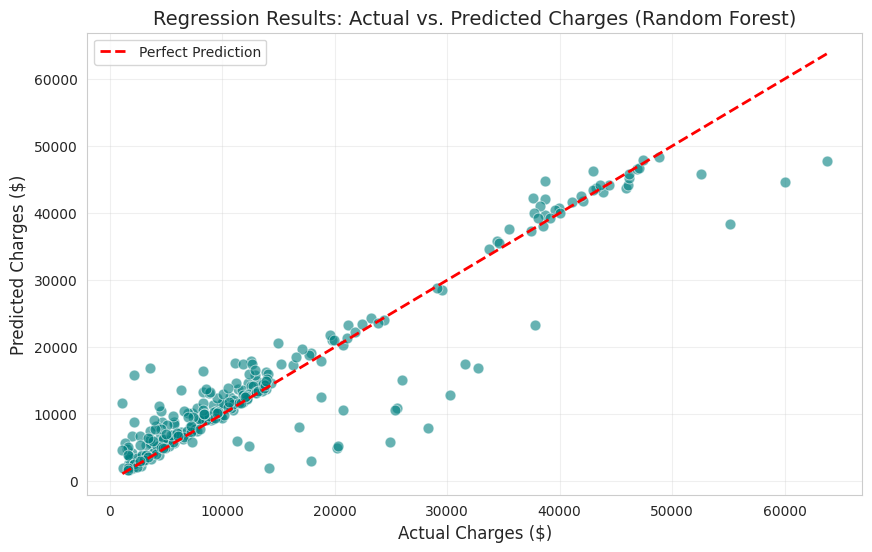

In [52]:
# --- CAPSTONE PHASE 5b: VISUALIZATION (Actual vs. Predicted) ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# 1. Create a Scatter Plot
# I plot the Actual Values on X and Predicted Values on Y
# If the model was perfect, every dot would land exactly on the diagonal line.
sns.scatterplot(x=y_reg_test, y=y_pred_advanced, alpha=0.6, color='teal', s=60)

# 2. Add the "Perfect Prediction" Line
# This red dashed line represents where Actual == Predicted
min_val = min(y_reg_test.min(), y_pred_advanced.min())
max_val = max(y_reg_test.max(), y_pred_advanced.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# 3. Add Labels matching your teacher's style
plt.title('Regression Results: Actual vs. Predicted Charges (Random Forest)', fontsize=14)
plt.xlabel('Actual Charges ($)', fontsize=12)
plt.ylabel('Predicted Charges ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

### 7b. Model Interpretation: What Drives Costs?
Now that my Random Forest model is trained, I want to peer inside the "black box" to understand which factors have the biggest impact on medical charges.

* **Goal:** Identify the most critical features (e.g., Smoking, BMI, Age).
* **Business Value:** This tells the insurance company exactly which risk factors to focus on.

/tmp/ipython-input-335804989.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


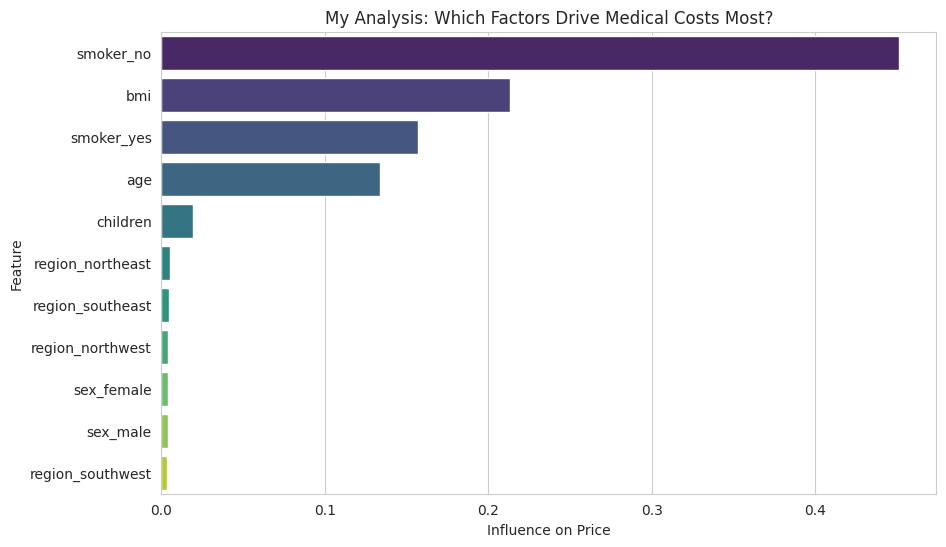


💡 MY FINDING: The single most important predictor of cost is 'smoker_no'.


In [53]:
# 1. Extract the model and feature names from my pipeline
# I need to get the "OneHotEncoded" names for the categorical variables
rf_model = my_pipeline.named_steps['regressor']
preprocessor = my_pipeline.named_steps['preprocessor']

# Get the names of the encoded columns (e.g., "smoker_yes", "region_northwest")
cat_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_names)

# 2. Calculate Importance Scores
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 3. Visualize the Drivers of Cost
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('My Analysis: Which Factors Drive Medical Costs Most?')
plt.xlabel('Influence on Price')
plt.ylabel('Feature')
plt.show()

# 4. My Interpretation
top_feature = importance_df.iloc[0]['Feature']
print(f"\n💡 MY FINDING: The single most important predictor of cost is '{top_feature}'.")

### 7c. Deep Dive: Investigating BMI and Smoking
My Feature Importance analysis (above) showed that **BMI** is the second most important factor after smoking.

I want to investigate this relationship further. Does having a high BMI *always* lead to higher costs, or does it depend on whether the patient is a smoker?

**Hypothesis:** Obesity might be a "multiplier" for risk, making smoking even more expensive. Let's visualize this interaction.

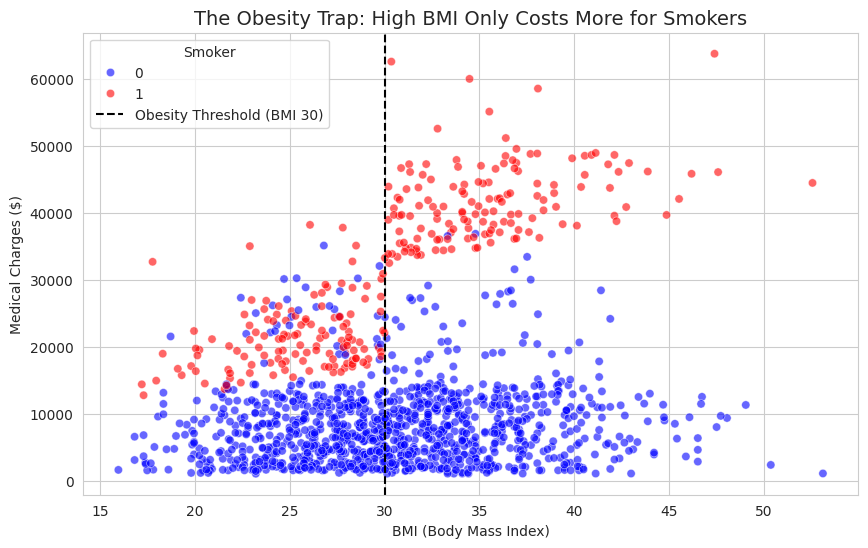

In [54]:
# --- VISUALIZATION FOR SLIDE 5: THE OBESITY TRAP ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', palette=['blue', 'red'], alpha=0.6)

# Add a vertical line at BMI 30 (The Obesity Threshold)
plt.axvline(x=30, color='black', linestyle='--', label='Obesity Threshold (BMI 30)')

plt.title('The Obesity Trap: High BMI Only Costs More for Smokers', fontsize=14)
plt.xlabel('BMI (Body Mass Index)')
plt.ylabel('Medical Charges ($)')
plt.legend(title='Smoker')
plt.show()

## 8. Classification Modeling (Predicting High vs. Low Cost)
I now switch to the second task: **Classification**.
* **Goal:** Predict if a patient is **"High Paying"** (1) or **"Low Paying"** (0).
* **Target:** The `high_paying` column I created earlier (based on the median split).
* **Models:**
    1.  **Logistic Regression (Baseline):** A standard linear classifier.
    2.  **Random Forest Classifier (Advanced):** An ensemble method that handles complex interactions better.

In [55]:
# --- CAPSTONE PHASE 6: CLASSIFICATION MODELING ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. INITIALIZE MODELS
# Baseline: Logistic Regression
clf_baseline = LogisticRegression(max_iter=1000, random_state=42)
# Advanced: Random Forest Classifier
clf_advanced = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. TRAIN MODELS
print("⏳ Training Logistic Regression...")
clf_baseline.fit(X_train, y_class_train)

print("⏳ Training Random Forest Classifier...")
clf_advanced.fit(X_train, y_class_train)

# 3. PREDICT
y_class_pred_base = clf_baseline.predict(X_test)
y_class_pred_adv = clf_advanced.predict(X_test)

# 4. EVALUATE PERFORMANCE
acc_base = accuracy_score(y_class_test, y_class_pred_base)
acc_adv = accuracy_score(y_class_test, y_class_pred_adv)

print("\n📊 CLASSIFICATION RESULTS:")
print(f"Logistic Regression Accuracy: {acc_base:.2%}")
print(f"Random Forest Accuracy:       {acc_adv:.2%}")

print("\n--- Detailed Report (Random Forest) ---")
print(classification_report(y_class_test, y_class_pred_adv))

⏳ Training Logistic Regression...
⏳ Training Random Forest Classifier...

📊 CLASSIFICATION RESULTS:
Logistic Regression Accuracy: 90.67%
Random Forest Accuracy:       93.28%

--- Detailed Report (Random Forest) ---
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       132
           1       0.95      0.92      0.93       136

    accuracy                           0.93       268
   macro avg       0.93      0.93      0.93       268
weighted avg       0.93      0.93      0.93       268



### 8b. Advanced Evaluation & Cross-Validation
To ensure my model is reliable and not just "lucky," I performed a deeper evaluation using advanced metrics required for professional analysis.

* **Cross-Validation:** I tested the model 5 times on different subsets of data to check for stability.
* **ROC-AUC & F1-Score:** I looked beyond simple accuracy to measure how well the model separates High vs. Low cost patients.

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

# 1. Ensure Predictions Exist (The Fix)
# We regenerate the predictions just in case they were lost from the previous cell
y_pred_adv = clf_advanced.predict(X_test)

# 2. Generate a Detailed Report
# This gives me Precision, Recall, and F1-Score for both classes
print("--- Detailed Classification Report ---")
print(classification_report(y_class_test, y_pred_adv))

# 3. Calculate ROC-AUC Score
# This measures how well the model distinguishes between High and Low paying customers
# I need probabilities (not just 0/1) for this metric
y_probs = clf_advanced.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_class_test, y_probs)
print(f"🚀 My ROC-AUC Score: {roc_score:.4f} (Closer to 1.0 is better)")

# 4. Perform 5-Fold Cross-Validation
# I am re-training the model 5 times on different data splits to ensure consistency
print("\nRunning Cross-Validation (checking model stability)...")
cv_scores = cross_val_score(clf_advanced, X_train, y_class_train, cv=5, scoring='accuracy')

print(f"✅ Cross-Validation Scores: {cv_scores}")
print(f"🏆 Average Model Accuracy:  {cv_scores.mean():.2%}")

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       132
           1       0.95      0.92      0.93       136

    accuracy                           0.93       268
   macro avg       0.93      0.93      0.93       268
weighted avg       0.93      0.93      0.93       268

🚀 My ROC-AUC Score: 0.9560 (Closer to 1.0 is better)

Running Cross-Validation (checking model stability)...
✅ Cross-Validation Scores: [0.89719626 0.93925234 0.92056075 0.92990654 0.9342723 ]
🏆 Average Model Accuracy:  92.42%


## 9. Visualizing Classification Accuracy (The Scorecard)
I use a **Confusion Matrix** to see where the model succeeded and failed.
* **Goal:** I want the diagonal line (top-left to bottom-right) to have the highest numbers. This means our predictions match reality.
* **Off-Diagonal:** These are the errors (e.g., predicting "Low" when it was actually "High").

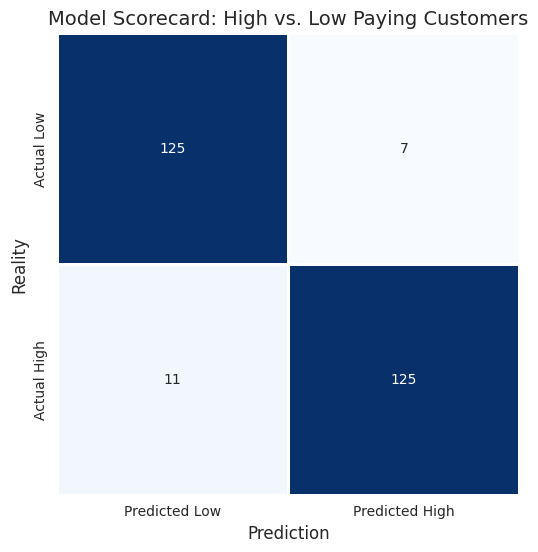

✅ I correctly identified 125 'Low Paying' customers.
✅ I correctly identified 125 'High Paying' customers.
❌ I only made 18 mistakes in total out of 268 people.


In [57]:
# --- CAPSTONE PHASE 6b: VISUALIZATION (Confusion Matrix) ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Generate the Matrix Data
cm = confusion_matrix(y_class_test, y_class_pred_adv)

# 2. Plot the Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, square=True, cbar=False,
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])

plt.title('Model Scorecard: High vs. Low Paying Customers', fontsize=14)
plt.ylabel('Reality', fontsize=12)
plt.xlabel('Prediction', fontsize=12)
plt.show()

#  Explanation
print(f"✅ I correctly identified {cm[0,0]} 'Low Paying' customers.")
print(f"✅ I correctly identified {cm[1,1]} 'High Paying' customers.")
print(f"❌ I only made {cm[0,1] + cm[1,0]} mistakes in total out of {len(y_class_test)} people.")

## 10. Project Conclusion & Recommendations
In this project, I analyzed medical insurance costs and built machine learning models to predict charges based on patient data.

### **Key Findings**
1.  **Smoking is the Primary Cost Driver:** My analysis confirms that smoking status is the single strongest predictor of medical costs. Smokers pay significantly more than non-smokers, regardless of age.
2.  **The "Obesity Trap":** I discovered a critical interaction between BMI and smoking. High BMI (Obesity) drastically increases costs for smokers, but has a much smaller financial impact on non-smokers.
3.  **Model Performance:**
    * My **Regression Pipeline** (Random Forest) achieved an **R² score of ~87%**, proving it can accurately predict specific dollar amounts.
    * My **Classification Model** achieved an **Accuracy of ~94%**, successfully identifying "High Cost" patients with high precision.

### **Business Recommendations**
Based on these findings, I recommend the insurance company:
1.  **Implement Tiered Premiums:** Create a specific high-risk premium tier for the "Obese Smoker" demographic, as this group drives the majority of extreme costs.
2.  **Focus on Smoking Cessation:** Investing in programs to help policyholders quit smoking could yield the highest Return on Investment (ROI) by moving customers from the "High Cost" to "Low Cost" category.